In [1]:
%%time
# Purpose: Plotting the accumulated ocean heat content and net surface 
#          heating anomalies to see where ocean takes up heat and where it
#          stores it
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 12. 08. 2020      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/'
save = '/g/data/e14/mv7494/HeatDist_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                       
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps     
import itertools
import cosima_cookbook as cc
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.patheffects as PathEffects
from scipy import stats
from wrf import to_np # conversion to arrays required for arrows on maps                                

import warnings
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import cftime


from cdo import *
cdo = Cdo()
import os
import sys

# for displaying multiple output in one cell
from IPython.display import display as dp

# colours                                                                                               
# ------------------------------------------------------------------------------------------------------------- #
#  ----                                 Colours from the RdBu_r colour bar                                  ---- #
dark_red   = [.40,.00,.12];   light_red = [.93,.58,.45]; dark_red2 =   [.76,.21,.22]; light_red2 = [.97,.72,.6 ] #
light_blue = [.49,.72,.84];   dark_blue = [.02,.19,.38]; light_blue2 = [.18,.47,.71]; dark_blue2 = [.53,.75,.85] #
# ----------------------------------------------------------------------------------- -------------------------- #
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

from dask.distributed import Client
client = Client(n_workers=16)
client

CPU times: user 4.97 s, sys: 4.57 s, total: 9.54 s
Wall time: 42.2 s


Client Scheduler: tcp://127.0.0.1:35803 Dashboard: /proxy/8787/status,Cluster Workers: 16 Cores: 16 Memory: 80.00 GiB


In [2]:
# -------------------------------------------------------------------------------------------------------------------- #
print('--- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---')   #
run    = ['1deg_jra55_rdf_branch2000_Control_PI_Offset/','1deg_jra55_iaf_branch2000_PI_Offset/']

exp    = ['ctrl_PI_Offset','iaf_PI_Offset']
                                  
base   = '/g/data/e14/mv7494/access-om2/archive/'                                                                      #
out    = '1deg_jra55_iaf_branch2000_trend/'                                                                            #
print('Creating the full Figure with data from:             ' + run[1])                                                #
print('--- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---')   #
# ----------------------------------------------------------------------------------------------------------           #


--- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
Creating the full Figure with data from:             1deg_jra55_iaf_branch2000_PI_Offset/
--- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---


### Top panel with the map

In [3]:
%%time
dzt = xr.open_mfdataset(base+run[0]+'output*/ocean/ocean.nc',decode_times=True).dzt.sel(time = slice('1972-01','2017-12')) 
area_t = xr.open_dataset(base+run[0]+'output200/ocean/ocean_grid.nc').area_t
dxt = xr.open_dataset(base+run[0]+'output200/ocean/ocean_grid.nc').dxt
dyt = xr.open_dataset(base+run[0]+'output200/ocean/ocean_grid.nc').dyt
rho_0 = 1035.0                       # [kg m^{-3}]
C_p = 3992.10322329649               # [J kg^{-1} K^{-1}]

# load in climatological temperature distribution as well
temp_clim_contour = xr.open_mfdataset(base+'1deg_jra55_rdf_branch2000_Control_PI_Offset/output*/ocean/ocean.nc').temp
temp_clim_contour1 = temp_clim_contour.isel(yt_ocean=slice(0,138)).mean(['time','xt_ocean']) - 273.15
temp_clim_contour2 = temp_clim_contour.isel(yt_ocean=slice(0,138)).mean(['time','yt_ocean']) - 273.15

temp_access = xr.open_dataset(base+out+'trend_temp_iaf_PI_Offset_1972-2017.nc').temp
OHC_1deg_map      = (rho_0*C_p*temp_access*dzt[0,:,:]).sum(['time','st_ocean']) # units of (J m-2 year-1)
OHC_1deg_right    = (rho_0*C_p*temp_access*dxt).sum(['time']).isel(yt_ocean=slice(0,138)).sum(['xt_ocean']) # only select Southern Hemisphere
OHC_1deg_left     = (rho_0*C_p*temp_access*dyt).sum(['time']).isel(yt_ocean=slice(0,138)).sum(['yt_ocean']) # units of (J m-2 year-1)

# Wall time: 665 ms

CPU times: user 1.79 s, sys: 790 ms, total: 2.58 s
Wall time: 5.4 s


### Figure with global OHU

CPU times: user 6.72 s, sys: 961 ms, total: 7.68 s
Wall time: 16.2 s


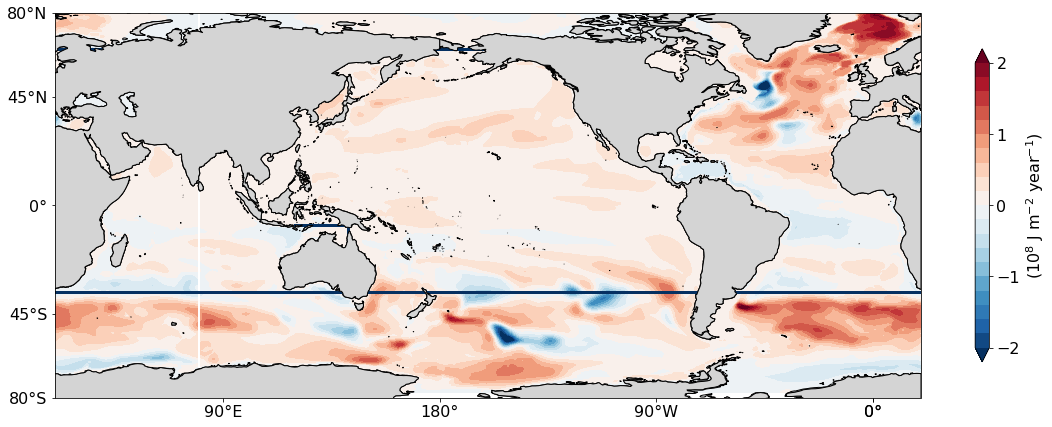

In [4]:
%%time
def fancy_plot(axes_nr):
    axes_nr.coastlines(resolution = '50m') # add coast lines
    axes_nr.set_xticks([0,90,180,270,360], crs=ccrs.PlateCarree())   
    axes_nr.set_yticks([-80,-45,0,45,80], crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter();
    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
    axes_nr.yaxis.set_major_formatter(lat_formatter) # "       "       "
    axes_nr.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
    axes_nr.xaxis.label.set_visible(False) # no axis labels
    axes_nr.yaxis.label.set_visible(False)
    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels   
plot_range = [-80,80]
ticks = np.linspace(-8,8,num=21) # ticks for colour bar
      
# initialise figure
fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,2)#, height_ratios=[1,1,1]) 

# --------------------------------------------------------------------------- #
# --- subplot 1: MAP -------------------------------------------- #
# --------------------------------------------------------------------------- #

# Qnet_1deg_map = xr.open_dataset(base+out+'trend_net_sfc_heating_average_DT_iaf_PI_Offset_1972-2017_clim_trend_removed.nc').net_sfc_heating.squeeze()

ax1 = plt.subplot(gs[:,:], projection=ccrs.PlateCarree(central_longitude=200)) # longitude starting at Cape Agulhas (20°E) 

ticks = np.linspace(-2,2,num=21) # ticks for colour bar
ax1.set_extent([1, 360, plot_range[0], plot_range[1]], crs=ccrs.PlateCarree())
# plot the data
p1 = (OHC_1deg_map/1e8).plot.contourf(cmp='RdBu_r',levels=ticks, add_colorbar=False,extend='both',transform=ccrs.PlateCarree())

fancy_plot(ax1) # add land boundaries, fill in land and add labels in °S/°N form
ax1.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 1)
# # add colour bar   
cb = plt.colorbar(p1, shrink=.5, orientation='vertical', location='right'); 
cb.set_label(label='(10$^{8}$ J m$^{-2}$ year$^{-1}$)', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator;cb.update_ticks() 
plt.title('')

# ocean basin boundaries
plt.plot([-359, 0], [-36, -36],color = rotblau[20], linewidth=3, transform=ccrs.PlateCarree(),)
plt.plot([142, 142], [-4,  -20], color = rotblau[20], linewidth=3, transform=ccrs.PlateCarree(),) # New Guinea to Arnhem Land line
plt.plot([120, 142], [-8,  -8], color = rotblau[20], linewidth=3, transform=ccrs.PlateCarree(),) # New Guinea to Java
plt.plot([10, 200], [65,  65], color = rotblau[20], linewidth=3, transform=ccrs.PlateCarree(),) # Bering Strait

# --------------------------------------------------------------------------- #
# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
# --- end of script --------------------------------------------------------- #
plt.savefig(save + 'SCHEMATIC_figure_top_panel_full', 
            dpi=700, facecolor='w',
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches='tight', 
            pad_inches=0.1, metadata=None)
# --- end of script --------------------------------------------------------- #
# Wall time: 14.3 s

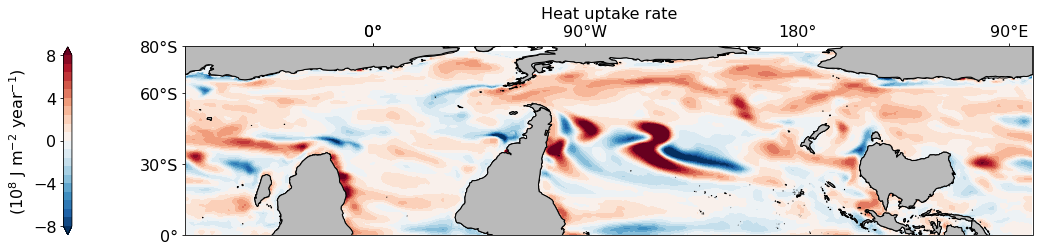

In [4]:
def fancy_plot(axes_nr):
    axes_nr.coastlines(resolution = '50m') # add coast lines
    axes_nr.set_xticks([0,90,180,270,360], crs=ccrs.PlateCarree())   
    axes_nr.set_yticks([-80,-60,-30,0], crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter();
    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
    axes_nr.yaxis.set_major_formatter(lat_formatter) # "       "       "
    axes_nr.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.73,.73,.73], zorder = 2)
    axes_nr.xaxis.label.set_visible(False) # no axis labels
    axes_nr.yaxis.label.set_visible(False)
    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels   
plot_range = [-80,0]
ticks = np.linspace(-8,8,num=21) # ticks for colour bar
      
# initialise figure
fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,2)#, height_ratios=[1,1,1]) 

# --------------------------------------------------------------------------- #
# --- subplot 1: MAP -------------------------------------------- #
# --------------------------------------------------------------------------- #

Qnet_1deg_map = xr.open_dataset(base+out+'trend_net_sfc_heating_average_DT_iaf_PI_Offset_1972-2017_clim_trend_removed.nc').net_sfc_heating.squeeze()


ax1 = plt.subplot(gs[:,:], projection=ccrs.PlateCarree(central_longitude=260)) # longitude starting at Cape Agulhas (20°E) 

ticks = np.linspace(-8,8,num=21) # ticks for colour bar
ax1.set_extent([1, 360, plot_range[0], plot_range[1]], crs=ccrs.PlateCarree())
# plot the data
p1 = (Qnet_1deg_map/1e8).plot.contourf(cmp='RdBu_r',levels=ticks, add_colorbar=False,extend='both',transform=ccrs.PlateCarree())

fancy_plot(ax1) # add land boundaries, fill in land and add labels in °S/°N form
ax1.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 1)
# # add colour bar   
cb = plt.colorbar(p1, shrink=.3, orientation='vertical', location='left'); 
cb.set_label(label='(10$^{8}$ J m$^{-2}$ year$^{-1}$)', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator;cb.update_ticks() 
ax1.xaxis.tick_top() # axis labels on top
plt.title('Heat uptake rate', fontsize=16)
plt.gca().invert_yaxis() # reverse y axis so that Antarctica is at the top
plt.gca().invert_xaxis() # reverse x axis so that Australia is in the East
# --------------------------------------------------------------------------- #
# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
# --- end of script --------------------------------------------------------- #
plt.savefig(save + 'SCHEMATIC_figure_top_panel', 
            dpi=600, facecolor='w',
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches='tight', 
            pad_inches=0.1, metadata=None)
# --- end of script --------------------------------------------------------- #
# Wall time: 

### Side panels

CPU times: user 1.85 s, sys: 523 ms, total: 2.38 s
Wall time: 11.8 s


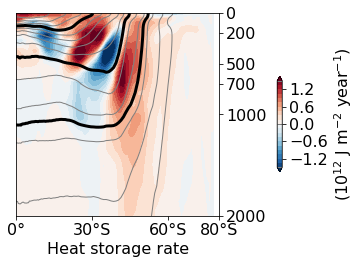

In [5]:
%%time
# initialise figure
fig = plt.figure(figsize=(3.9,5.3),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,2) 
                                                                            # only select 80°S-80°N
OHC_1deg_right    = (rho_0*C_p*temp_access*dxt).sum(['xt_ocean']).isel(yt_ocean=slice(0,279)).squeeze() # units of (J m-1 year-1)


# --------------------------------------------------------------------------- #
# --- subplot 2: IAF_TROPICS30SN Depth-Latitude ----------------------------- #
# --------------------------------------------------------------------------- #
def fancy_plot2(axes_nr): # different function for the zonally-integrated depth-latitude plots
    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels
    plt.gca().invert_yaxis() # reverse y axis so it goes from surface (0 m) down to 2000 m 
    axes_nr.set_ylim([2000,0]); axes_nr.set_xlim([-80,0]) # set plot limits
    axes_nr.set_xticks([-80, -60,-30,0])
    axes_nr.set_yticks([2000,1000, 700, 500, 200, 0])
    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lat_formatter) # "       "       "
    # axes_nr.xaxis.label.set_visible(False) # no axis labels
    
ax1 = plt.subplot(gs[:,:], aspect=.04) 

# plot the data
ticks = np.linspace(-1.5,1.5,num=21) # ticks for colour bar

p2 = (OHC_1deg_right/1e12).plot.contourf(cmp='RdBu_r',levels=ticks, add_colorbar=False,extend='both')

# p11 = (OHC_1deg_depth/1e12).plot.contour(levels = [-6,-3,0,3,6],linewidths=1.0, colors='grey',interpolation='none')
p22 = temp_clim_contour1.plot.contour(levels = np.linspace(-4,30,18),linewidths=1.0, colors='grey',interpolation='none')
p222 = temp_clim_contour1.plot.contour(levels = [20, 10, 5],linewidths=3.0, colors='k',interpolation='none')
# plt.clabel(p22, inline_spacing=1, fontsize=16, fmt="%.1i")
fancy_plot2(ax1)
ax1.set_xlabel('Heat storage rate', fontsize=16)
plt.gca().invert_xaxis()


# add colour bar  
# cb = plt.colorbar(p2, shrink=.2, orientation='vertical', location='right')
cax = fig.add_axes([1, .35, .018, .25]) # position: [x0, y0, width, height]
cb = plt.colorbar(p2, cax = cax, shrink=1.25, orientation='vertical'); 
cb.set_label(label='(10$^{12}$ J m$^{-2}$ year$^{-1}$)', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator;cb.update_ticks()
cb.add_lines(p22) # add contours to colour bar
ax1.set_ylabel('')
# plt.plot([0,300], [-32, -32],color = rotblau[20], linewidth=3)
ax1.yaxis.tick_right() # axis labels on right

# --------------------------------------------------------------------------- #
# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
# --- end of script --------------------------------------------------------- #
plt.savefig(save + 'SCHEMATIC_figure_right_panel', 
            dpi=600, facecolor='w',
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches='tight', 
            pad_inches=0.1, metadata=None)
# --- end of script --------------------------------------------------------- #

CPU times: user 2.11 s, sys: 453 ms, total: 2.56 s
Wall time: 6.41 s


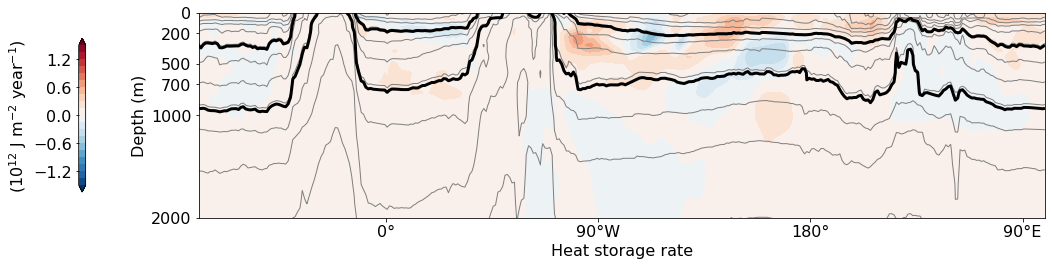

In [6]:
%%time 
# initialise figure
fig = plt.figure(figsize=(31.8,6.8),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,2) 
# --------------------------------------------------------------------------- #
# --- subplot 2: IAF_TROPICS30SN Depth-Latitude ----------------------------- #
# --------------------------------------------------------------------------- #
ax1 = plt.subplot(gs[1,0]) # longitude starting at Cape Agulhas (20°E) 
    
ticks = np.linspace(-1.5,1.5,21)
p3 = (OHC_1deg_left/1e12).plot.contourf(cmp='RdBu_r',levels=ticks, add_colorbar=False,extend='both')
p33 = temp_clim_contour2.plot.contour(levels = np.linspace(-3,30,21),linewidths=1.0, colors='grey',interpolation='none')
p333 = temp_clim_contour2.plot.contour(levels = [20, 10, 5],linewidths=3.0, colors='k',interpolation='none')

plt.clabel(p22, inline_spacing=1, fontsize=16, fmt="%.1i")
# fancy_plot3(ax1)
# # add colour bar   
cb = plt.colorbar(p3, shrink=.75, orientation='vertical', location='left'); 
cb.set_label(label='(10$^{12}$ J m$^{-2}$ year$^{-1}$)', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator;cb.update_ticks() 
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_ylabel('Depth (m)', fontsize=16)
ax1.set_ylim([0,300]); ax1.set_yticks([2000, 1000, 700, 500, 200, 0]); ax1.set_xticks([-270,-180,-90,0]) # 100°E-100°W
plt.gca().invert_yaxis() # reverse y axis so it goes from surface (0 m) down to 2000 m 

labels = [item.get_text() for item in ax1.get_xticklabels()]
labels =       ['90°E', '180°', '90°W', '0°']; ax1.set_xticklabels(labels)
plt.xlabel('Heat storage rate', fontsize=16)
plt.gca().invert_xaxis()

# --------------------------------------------------------------------------- #
# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
# --- end of script --------------------------------------------------------- #
plt.savefig(save + 'SCHEMATIC_figure_left_panel', 
            dpi=600, facecolor='w',
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches='tight', 
            pad_inches=0.1, metadata=None)
# --- end of script --------------------------------------------------------- #
# Wall time: 14.2 s